In [1]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import openml

In [2]:
dataset = openml.datasets.get_dataset("41026")
gisette, gisette_labels, _, _ = dataset.get_data(target=dataset.default_target_attribute)


C:\Users\agata\AppData\Local\Programs\Python\Python312\Lib\site-packages\openml\datasets\dataset.py:472: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.factorize(type_)[0]


In [3]:
np.unique(gisette_labels)

array([0, 1])

In [4]:
# no missing values
gisette.isnull().sum().sum()

np.int64(0)

In [5]:
gisette.shape

(7000, 5000)

In [6]:
# remove columns with constant values
gisette = gisette.loc[:, (gisette != gisette.iloc[0]).any()]
gisette.shape

C:\Users\agata\AppData\Local\Temp\ipykernel_36112\3732148646.py:2: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[np.True_, False]'. Picking the first and converting the rest.
  gisette = gisette.loc[:, (gisette != gisette.iloc[0]).any()]


(7000, 4971)

In [7]:
print(gisette.min().min(), gisette.max().max())
np.sort(gisette.max())[-10:]

-1.0 3.17336


array([1.75254, 1.78014, 1.79704, 1.94   , 2.05864, 2.22779, 2.3617 ,
       2.4103 , 3.10352, 3.17336], dtype=float32)

C:\Users\agata\AppData\Local\Temp\ipykernel_36112\3451440435.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(gisette.iloc[:, :5], labels=[f"Feature {i}" for i in range(1, 6)])


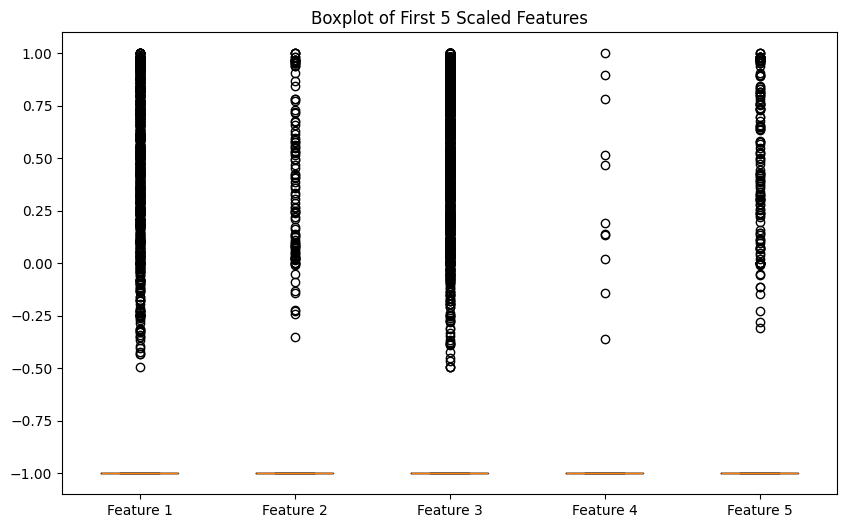


Training Label Distribution:
 class
1    3500
0    3500
Name: count, dtype: int64


In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(gisette.iloc[:, :5], labels=[f"Feature {i}" for i in range(1, 6)])
plt.title("Boxplot of First 5 Scaled Features")
plt.show()

# Label Distribution
train_label_counts = gisette_labels.value_counts()
print("\nTraining Label Distribution:\n", train_label_counts)

In [9]:
def remove_highly_correlated_features(df, threshold=0.7):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    
    print(f"Removing {len(to_drop)} highly correlated features.")
    return df.drop(columns=to_drop)

In [10]:
# remove features with VIF > 10
gisette = remove_highly_correlated_features(gisette)

Removing 1257 highly correlated features.


In [11]:
# check number of features left
print(f"Number of features left: {gisette.shape[1]}")

Number of features left: 3714


In [12]:
gisette_cleaned = gisette.copy()

In [13]:
# create dummy variables
n_obs, n_features = gisette_cleaned.shape
min_features = n_obs // 2

i = 0
new_columns = {}
while gisette_cleaned.shape[1] + len(new_columns) < min_features:
    col_to_copy = np.random.choice(gisette_cleaned.columns)
    new_columns[f"{col_to_copy}_perm_{i}"] = np.random.permutation(gisette_cleaned[col_to_copy].values)
    i += 1

df = pd.concat([gisette_cleaned, pd.DataFrame(new_columns)], axis=1)

df.shape


(7000, 3714)

In [14]:
# Convert to dense format (regular pandas Series)
gisette_labels_dense = gisette_labels.sparse.to_dense()

# Rename the column if needed
gisette_labels_dense.rename('label', inplace=True)

# Optionally replace the original variable
gisette_labels = gisette_labels_dense


In [15]:
df = pd.concat([gisette_cleaned, pd.DataFrame(gisette_labels)], axis=1)
df.shape

(7000, 3715)

In [21]:
df.head(3)

,att_1,att_2,att_3,att_4,att_5,att_6,att_7,att_8,att_9,att_10,...,att_4987,att_4988,att_4989,att_4990,att_4994,att_4997,att_4998,att_4999,att_5000,label
0,0.101101,-1.0,-0.009009,-1.0,-1.0,-1.0,-1.0,0.953954,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,0.983984,-1.0,-1.0,-1.0,0.967968,1
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.953954,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,0.983984,0.983984,-1.0,-1.0,-1.0,0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,0.233233,-1.0,-1.0,-1.0,-1.0,-1.0,1


In [18]:
df.to_csv('data/preprocessed_gisette.csv', index=False, header = False)